In [181]:
import numpy as np
# %config InlineBackend.rc={}
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
# import scipy.io as sio
import datetime
import h5py

In [182]:
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

In [183]:
import time

In [184]:
fit_filename="/mnt/Work_disk/Owncloud/0000_Two_points/DATA/02_KEO/140824/20140824_2507.fit";
dark_filename="/mnt/Work_disk/Owncloud/0000_Two_points/DATA/02_KEO/140824/dark/keo_aug24_dark_median.fit";
ppm_bright_filename="/mnt/Work_disk/Owncloud/0000_Two_points/01_Cam_orient/ppm_bright.mat"

In [185]:
# Координаты расположения KEO
lat_keo=55.9305361 # ШИРОТА
lon_keo=48.7444861 # ДОЛГОТА
h_keo=91.0
KEO_site=EarthLocation(lat=lat_keo*u.deg, lon=lon_keo*u.deg, height=h_keo*u.m)

# Ориентация KEO - 24 августа
az0_keo = 6.0729592128071603;
alt0_keo = 1.5428754318596944;
a_keo = (   1.1260974991748651,   -0.0048692544335450,    0.0004054871474967)
b_keo = (   1.3414326667154699,   -0.0003973836009369,   -0.0048666234384367)
c_keo = ( 252.5023732028608379, -203.9735999213842206,  -16.9930115762693461)
d_keo = ( 255.0212588337721229,   16.6581624996323754, -204.0858265523006594)

In [186]:
fid_ppm_bright=h5py.File(ppm_bright_filename,'r')
ppm_bright=fid_ppm_bright['ppm_bright']
ppm_bright=np.transpose(ppm_bright)

In [187]:
fid_fit=fits.open(fit_filename);
date_obs_str=fid_fit[0].header["DATE-OBS"]
img=fid_fit[0].data;
img=img.astype('d')
fid_fit.close()
dark=fits.getdata(dark_filename);
dark.astype('d')
img=img-dark
date_obs=datetime.datetime.strptime(date_obs_str,"%Y-%m-%dT%H:%M:%S")+datetime.timedelta(seconds=15)
print(date_obs)

2014-08-24 20:43:15


In [188]:
ppm_coord=SkyCoord(ppm_bright[:,2], ppm_bright[:,3], frame='icrs', unit='deg');

ppm_altaz=ppm_coord.transform_to(AltAz(obstime=date_obs, location=KEO_site,temperature=15*u.deg_C,pressure=1013*u.hPa,
                                       relative_humidity=0.5,obswl=630.0*u.nm))

In [189]:
ppm_bright[:,1]=ppm_altaz.az.degree
ppm_bright[:,2]=ppm_altaz.alt.degree

In [208]:
def cart2spheric(x,y,z):
    r=np.sqrt(x*x+y*y+z*z)
    phi=np.arctan2(y,x)
    theta=np.arccos(z/r)
    return (r, phi, theta)

def spheric2cart(r,phi,theta):
    x=r*np.sin(theta)*np.cos(phi)
    y=r*np.sin(theta)*np.sin(phi)
    z=r*np.cos(theta)
    return (x, y, z)

def spheric_coordinates_rotate(A,h,A0,h0):
    (x,y,z) = spheric2cart(np.ones(np.size(A)),A, np.pi/2-h)
    dz=np.pi/2-h0;
    
    x_new=x*np.cos(-dz)*np.cos(-A0)-y*np.sin(-A0)*np.cos(-dz)+z*np.sin(-dz);
    y_new=x*np.sin(-A0)+y*np.cos(-A0);
    z_new=-x*np.sin(-dz)*np.cos(-A0)+y*np.sin(-dz)*np.sin(-A0)+z*np.cos(-dz)
    
    r_new, A_new, zen_new =cart2spheric(x_new,y_new,z_new);
    h_new=np.pi/2-zen_new;
    
    return (A_new, h_new)

def hor2pix_keo(Az,Alt,az0,alt0):
    Azrot, Altrot = spheric_coordinates_rotate(Az,Alt,az0,alt0,c,d)
    X=(np.pi/2-Altrot)*np.cos(Azrot)
    Y=(np.pi/2-Altrot)*np.sin(Azrot)
    x=c[0]+c[1]*X+c[2]*Y; # xpix
    y=d[0]+d[1]*X+d[2]*Y; # ypix/
    return x, y
    

In [191]:
Azrot, Altrot = spheric_coordinates_rotate(ppm_bright[:,1]*np.pi/180,ppm_bright[:,2]*np.pi/180,az0_keo,alt0_keo)
X=(np.pi/2-Altrot)*np.cos(Azrot)
Y=(np.pi/2-Altrot)*np.sin(Azrot)
ppm_bright[:,3]=c_keo[0]+c_keo[1]*X+c_keo[2]*Y; # xpix
ppm_bright[:,4]=d_keo[0]+d_keo[1]*X+d_keo[2]*Y; # ypix

In [192]:
# ppm_bright filtration
filt_mask=np.zeros(np.size(ppm_bright,0),dtype=bool)
for i in range(0,np.size(ppm_bright,0)):
    if ppm_bright[i,2]>=44.0 and ppm_bright[i,2]<=62.0:
        if ppm_bright[i,3]>=1 and ppm_bright[i,3]<=511:
            if ppm_bright[i,4]>=1 and ppm_bright[i,4]<=511:
                if ppm_bright[i,0]!=44721.0:
                    filt_mask[i]=True
ppm_filt=ppm_bright[filt_mask,:]

In [193]:
np.size(ppm_filt,0)

3236

In [204]:
ppm_sptype_sort=np.load('ppm_sptype_sort.npy')
ppm_filt_sort=np.load('ppm_filt_sort.npy')

In [203]:
ppm_filt[0,6]

IndexError: index 7 is out of bounds for axis 1 with size 7

In [207]:
ppm_filt_sort[1,1:4]

array([ 104.48414261,   53.6034793 ,  305.75340597])

In [200]:
ppm_sptype_sort[1]

b'M0III'

In [18]:
print('Min:', np.min(img))
print('Max:', np.max(img))
print('Mean:', np.mean(img))
print('Median:', np.median(img))
print('Stdev:', np.std(img))

Min: -3916.0
Max: 65253.0
Mean: 373.881223647
Median: 506.0
Stdev: 487.25447757


In [160]:
img_red_st_int=[]
img_red_st_num=[]
area_rad=2
for j in range(np.size(ppm_filt_sort[:,5])):    
    st_x=ppm_filt_sort[j,3]
    st_y=ppm_filt_sort[j,4]
    area=img[int(st_y)-area_rad:int(st_y)+area_rad+1, int(st_x)-area_rad:int(st_x)+area_rad+1]

    sum_temp=0.0
    num=0
    med=np.median(area)
    for i in range(len(area.flat)):
        if area.flat[i]>=1.3*med:
            num+=1
            sum_temp+=area.flat[i]-med
    img_red_st_int.append(sum_temp)
    img_red_st_num.append(num)
#     print(sum)
#     print(num)

In [161]:
print(img_red_st_int)
print(img_red_st_num)

[25829.0, 7345.0, 149.0, 6745.0, 5819.0, 6018.0, 872.0, 3426.0, 2745.0, 2559.0, 1152.0, 1903.0, 2024.0, 628.0, 460.0, 943.0, 1416.0, 1098.0, 719.0, 256.0, 1433.0, 1227.0, 1293.0, 1165.0, 167.0, 941.0, 330.0, 380.0, 1464.0, 0.0, 325.0, 784.0, 779.0, 759.0, 517.0, 1060.0, 1073.0, 534.0, 407.0, 240.0, 286.0, 366.0, 397.0, 415.0, 200.0, 708.0, 278.0, 261.0, 636.0, 331.0, 201.0, 178.0, 493.0, 356.0, 772.0, 70.0, 327.0, 143.0, 11802.0, 316.0, 106.0, 536.0, 224.0, 382.0, 193.0, 576.0, 0.0, 178.0, 560.0, 496.0, 640.0, 561.0, 173.0, 0.0, 0.0, 215.0, 179.0, 464.0, 269.0, 168.0, 192.0, 0.0, 0.0, 197.0, 0.0, 375.0, 0.0, 288.0, 375.0, 0.0, 0.0, 191.0, 234.0, 0.0, 220.0, 176.0, 279.0, 0.0, 0.0, 1013.0, 177.0, 0.0, 0.0, 326.0, 0.0, 0.0, 389.0, 0.0, 208.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 640.0, 238.0, 0.0, 0.0, 0.0, 0.0, 0.0, 678.0, 0.0, 0.0, 0.0, 0.0, 473.0, 0.0, 0.0, 0.0, 0.0, 3566.0, 0.0, 0.0, 0.0, 0.0, 1172.0, 265.0, 212.0, 0.0, 217.0, 0.0, 0.0, 0.0, 0.0, 233.0, 171.0, 181.0, 60.0, 0.0, 0.

In [87]:
def bright_relay_keo(mv,m0,n):
    b=(10**(-0.4*mv-m0+12))/n*3.654
    return b

In [97]:
ppm_filt[i,5]

0.029999999329447746

In [96]:
ppm_sptype_sort[0][0:2]==b'A0'

True

In [162]:
bright_relay=np.zeros(np.size(ppm_filt_sort[:,5]))
for i in range(np.size(bright_relay)):
    if img_red_st_num[i]>=3:
        if ppm_sptype_sort[i][0:2]==b'B0':
            m0=8.58
            bright_relay[i]=bright_relay_keo(ppm_filt_sort[i,5],m0,
                                             img_red_st_num[i])
        elif ppm_sptype_sort[i][0:2]==b'A0':
            m0=8.56
            bright_relay[i]=bright_relay_keo(ppm_filt_sort[i,5],m0,
                                             img_red_st_num[i])
        elif ppm_sptype_sort[i][0:2]==b'F0':
            m0=8.53
            bright_relay[i]=bright_relay_keo(ppm_filt_sort[i,5],m0,
                                             img_red_st_num[i])
        elif ppm_sptype_sort[i][0:2]==b'G0':
            m0=8.50
            bright_relay[i]=bright_relay_keo(ppm_filt_sort[i,5],m0,
                                             img_red_st_num[i])
        elif ppm_sptype_sort[i][0:2]==b'K0':
            m0=8.42
            bright_relay[i]=bright_relay_keo(ppm_filt_sort[i,5],m0,
                                             img_red_st_num[i])
        elif ppm_sptype_sort[i][0:2]==b'M0':
            m0=8.33
            bright_relay[i]=bright_relay_keo(ppm_filt_sort[i,5],m0,
                                             img_red_st_num[i])    

In [163]:
Nfot=np.zeros(np.size(ppm_filt_sort[:,5]))
K_coef=np.zeros(np.size(ppm_filt_sort[:,5]))
for i in range(np.size(ppm_filt_sort[:,5])):
    if img_red_st_num[i]>0:
        Nfot[i]=img_red_st_int[i]/img_red_st_num[i]
    if Nfot[i]!=0.0 and bright_relay[i]>100:
        K_coef[i]=bright_relay[i]/Nfot[i]

In [113]:
np.size(bright_relay)

3236

In [175]:
# alpha Lyr
print(bright_relay[0])
print(Nfot[0])
print(1082.4975/Nfot[0])
print("")
# beta And
print(bright_relay[1])
print(Nfot[1])
print(385.19/Nfot[1])
print("")
# gamma Sge
print(bright_relay[10])
print(Nfot[10])
print(210.105/Nfot[10])
print("")
print(np.median([0.335281272988, 0.314654867257, 0.5471484375]))

1223.71013312
3228.625
0.335281272988

431.139001625
1224.16666667
0.314654867257

233.156365524
384.0
0.5471484375

0.335281272988


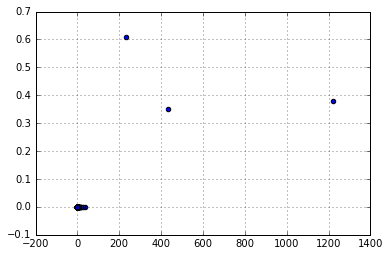

In [164]:
fig,ax = plt.subplots()
plt.scatter(bright_relay,K_coef)
ax.grid(True)
# ax.set_xlim((10, 1300))
# ax.set_ylim((0, 20))
plt.show()

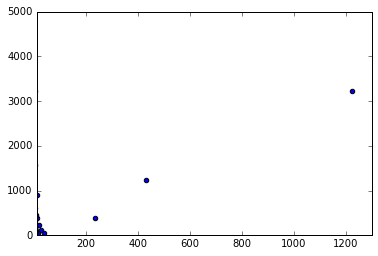

In [165]:
fig,ax = plt.subplots()
plt.scatter(bright_relay,Nfot)
ax.set_xlim((10, 1300))
ax.set_ylim((10, 5000))
plt.show()

In [166]:
print(bright_relay[0],Nfot [0])
print(bright_relay[1],Nfot [1])
print(bright_relay[10],Nfot [10])

1223.71013312 3228.625
431.139001625 1224.16666667
233.156365524 384.0


In [171]:
print(K_coef[0])
print(K_coef[1])
print(K_coef[10])
print('')
print(np.median([ K_coef[0], K_coef[1], K_coef[10]]))

0.379018973438
0.352189790299
0.607178035218

0.379018973438


In [135]:
bright_relay.nonzero()

(array([   0,    1,   10,   62,  124,  134,  211,  293,  310,  459,  539,
         551,  566,  622,  674,  728,  739,  880,  914,  925, 1018, 1033,
        1062, 1180, 1321, 1353, 1369, 1370, 1376, 1464, 1698, 1806, 1960,
        1988, 2060, 2068, 2085, 2475, 2571, 2633, 2644, 2663, 2701, 2876,
        2958, 2965, 3056, 3200]),)

In [47]:
fsqr_div_ap=57.650738*(10**(-2))
Fl_div_hc=652.46284*(10**20)

29.6

In [42]:
lambd=6300
F0=2058.3649
c=3*(10**10)
h=6.625*(10^-27)

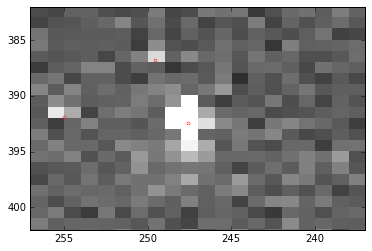

In [25]:
fig, ax = plt.subplots()
# plt.imshow(img, cmap="gray", vmin=300, vmax=900)
plt.pcolormesh(img, cmap="gray", vmin=300, vmax=1000)
#plt.colorbar
plt.plot(ppm_filt_sort[0:100,3],ppm_filt_sort[0:100,4],color="r",marker=".", lw=0.,mec="r", mfc="none")
ax.set_xlim([247+10,247-10]);
ax.set_ylim([392+10,392-10]);
# ax.set_xlim((511,1))
# ax.set_ylim((511,1))
plt.show()